In [ ]:
%load_ext autoreload
%autoreload 2



****

Be mindful of :
- label smoothing 
- loss on proba or log probas


**Data :**
*WalkingSittingStanding* from [UAE](https://www.timeseriesclassification.com/description.php?Dataset=WalkingSittingStanding)

For reference, a MiniRocket classifier gets accuracy of 92.7% on the default test data.

Best so far : 90 test % accuracy

- parameter tuning on the optimisation and, size, number of channels and loss parameters
- GL : L1 regularization to learn the manifolds during training
- add positional embedding in the transformer ?
- refresh expected path development section

In [32]:
import os
from aeon.datasets import load_from_tsfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch import Tensor
from torch.utils.data import DataLoader

from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch import nn
from typing import List
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

import random

In [33]:
from models.attention_development import (
    MultiheadAttentionDevelopment,
    GroupConfig,
    AttentionDevelopmentConfig,
)

from development.so import so
from development.he import he
from development.gl import gl

In [34]:
torch.cuda.is_available()

True

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Functions definition

In [66]:
def train_model(fm: nn.Module, nepochs: int, learning_rate: float):
    fm.train()
    optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
    lossx = []
    for epoch in tqdm(range(nepochs)):
        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            loss.backward()
            lossx.append(loss.item())
            optimizer.step()

        print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")

    return fm, lossx


def train_model_with_test_error(
    fm: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    nepochs: int,
    learning_rate: float,
):
    fm.train()
    optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
    lossx, lossx_test = [], []
    for epoch in tqdm(range(nepochs)):
        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            loss.backward()
            lossx.append(loss.item())
            optimizer.step()
        print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")

        if epoch % 4 != 0:
            continue
        # compute the test error
        fm.eval()
        for x, y in test_loader:
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            lossx_test.append(loss.item())
        fm.train()
    return fm, lossx, lossx_test


def train_sample_accuracy(fm: nn.Module):
    fm.eval()
    n_true_prediction = 0
    preds, trues = [], []
    for x, y in train_loader:
        y_hat = fm(x)
        y_pred = torch.argmax(y_hat, axis=1)
        y_true = torch.argmax(y, axis=1)
        n_true_prediction += torch.sum(y_pred == y_true).detach().cpu().numpy()
        preds = np.concatenate([preds, y_pred.detach().cpu().numpy()])
        trues = np.concatenate([trues, y_true.detach().cpu().numpy()])
    cm = confusion_matrix(trues, preds)
    ConfusionMatrixDisplay(cm).plot()
    return n_true_prediction / len(y_train)


def test_sample_accuracy(fm: nn.Module):
    fm.eval()
    n_true_prediction = 0
    preds, trues = [], []
    for x, y in test_loader:
        y_hat = fm(x)
        y_pred = torch.argmax(y_hat, axis=1)
        y_true = torch.argmax(y, axis=1)
        n_true_prediction += torch.sum(y_pred == y_true).detach().cpu().numpy()
        preds = np.concatenate([preds, y_pred.detach().cpu().numpy()])
        trues = np.concatenate([trues, y_true.detach().cpu().numpy()])

    cm = confusion_matrix(trues, preds)
    ConfusionMatrixDisplay(cm).plot()
    return n_true_prediction / len(y_test)


def train_model_l2(
    fm: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    nepochs: int,
    learning_rate: float,
    alpha: float,
):
    fm.train()
    optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
    lossx, lossx_test = [], []
    for epoch in range(nepochs):
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_hat = fm(x)
            sx = fm.forward_partial(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y) + alpha * sum(
                [torch.linalg.norm(s) for s in sx]
            )  # norm parameters
            loss.backward()
            lossx.append(loss.item())
            optimizer.step()

        print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")
        if epoch % 4 != 0:
            continue
        # compute the test error
        fm.eval()
        for x, y in test_loader:
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            lossx_test.append(loss.item())
        fm.train()

    return fm, lossx, lossx_test


def train_model_l1Lie(
    fm: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    nepochs: int,
    learning_rate: float,
    alpha: float,
):
    fm.train()
    optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
    lossx, lossx_test = [], []
    for epoch in range(nepochs):
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_hat = fm(x)
            lx = fm.lie_algebra_coefficients()
            loss = torch.sum((y - y_hat) ** 2) / len(y) + alpha * sum(
                [
                    torch.linalg.norm(
                        torch.linalg.norm(l, ord=1, dim=(2, 3)), ord=1, dim=(0, 1)
                    )
                    for l in lx
                ]
            )  # norm parameters
            loss.backward()
            lossx.append(loss.item())
            optimizer.step()

        print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")

        if epoch % 4 != 0:
            continue
        # compute the test error
        fm.eval()
        for x, y in test_loader:
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            lossx_test.append(loss.item())
        fm.train()

    return fm, lossx, lossx_test


def train_model_l1Lie_l2(
    fm: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    nepochs: int,
    learning_rate: float,
    alpha: float,
):
    fm.train()
    optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
    lossx, lossx_test = [], []
    for epoch in range(nepochs):
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_hat = fm(x)
            lx = fm.lie_algebra_coefficients()
            loss = (
                torch.sum((y - y_hat) ** 2) / len(y)
                + alpha
                * sum(  # norm parameters
                    [
                        torch.linalg.norm(
                            torch.linalg.norm(l, ord=1, dim=(2, 3)), ord=1, dim=(0, 1)
                        )
                        for l in lx
                    ]
                )
                + alpha * sum([torch.linalg.norm(s) for s in fm.forward_partial(x)])
            )
            loss.backward()
            lossx.append(loss.item())
            optimizer.step()

        print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")

        if epoch % 4 != 0:
            continue
        # compute the test error
        fm.eval()
        for x, y in test_loader:
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            lossx_test.append(loss.item())
        fm.train()

    return fm, lossx, lossx_test

## Load data

In [37]:
data_dir = os.path.join(os.getcwd(), "..", "data", "WalkingSittingStanding")
train_file = "WalkingSittingStanding_TRAIN.ts"
test_file = "WalkingSittingStanding_TEST.ts"

In [38]:
n_class = 6

tsx_train, y_train_labels = load_from_tsfile(os.path.join(data_dir, train_file))
tsx_test, y_test_labels = load_from_tsfile(os.path.join(data_dir, test_file))
# Convert labels to one-hot encoded vectors


def to_one_hot(y, num_classes=6):
    return np.eye(num_classes)[y.astype(int)]


# Convert to soft probabilities
def to_soft_probabilities(y_one_hot, temperature=0.2):
    exp_values = np.exp(y_one_hot / temperature)
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)


# Apply transformations
y_train = to_soft_probabilities(to_one_hot(y_train_labels.astype(float)))
y_test = to_soft_probabilities(to_one_hot(y_test_labels.astype(float)))

tsx_train = Tensor(tsx_train).swapaxes(1, 2).to(device)
tsx_test = Tensor(tsx_test).swapaxes(1, 2).to(device)

# Convert back to PyTorch tensors
y_train = torch.logit(torch.tensor(y_train, dtype=torch.float32)).to(device)
y_test = torch.logit(torch.tensor(y_test, dtype=torch.float32)).to(device)
tsx_train.shape, len(y_test)

(torch.Size([7352, 206, 3]), 2947)

In [39]:
tsx_train.shape, y_train.shape

(torch.Size([7352, 206, 3]), torch.Size([7352, 6]))

In [40]:
# Define batch size
batch_size = 256

# Create DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(tsx_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)
test_dataset = torch.utils.data.TensorDataset(tsx_test, y_test)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)

print(f"Number of batches: {len(train_loader)}")

Number of batches: 29


## Benchmark with a logistic regression

c:\code\DevNet\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\code\DevNet\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Train accuracy : 0.6764145810663765
Test accuracy : 0.5483542585680353


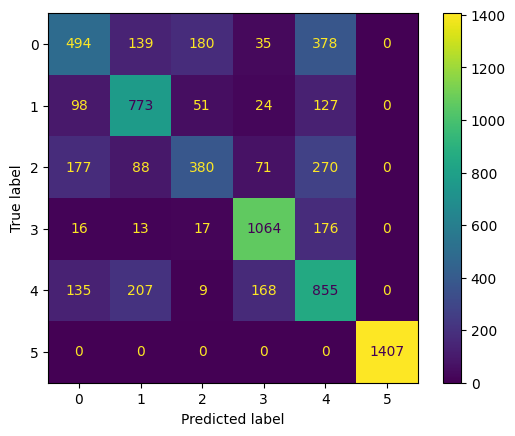

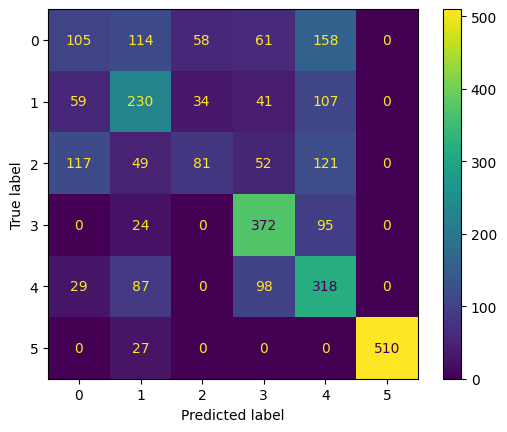

In [77]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=5)

model.fit(torch.flatten(tsx_train, start_dim=1).cpu().detach().numpy(), y_train_labels)

y_hat = model.predict(torch.flatten(tsx_train, start_dim=1).cpu().detach().numpy())
y_hat_test = model.predict(torch.flatten(tsx_test, start_dim=1).cpu().detach().numpy())

print(f"Train accuracy : {(y_hat == y_train_labels).sum() / len(y_hat)}")
print(f"Test accuracy : {(y_hat_test == y_test_labels).sum() / len(y_hat_test)}")
cm = confusion_matrix(y_train_labels, y_hat)
cm_test = confusion_matrix(y_test_labels, y_hat_test)
ConfusionMatrixDisplay(cm).plot()
ConfusionMatrixDisplay(cm_test).plot()

## Expected path development
- characterise the classes with the expected path development for each class
- then similarity test to classify test samples (HS distance ?)

In [138]:
def generate_derangement(n):
    while True:
        # Generate a random permutation of elements
        perm = list(range(n))
        random.shuffle(perm)

        # Check if it's a derangement
        if all(perm[i] != i for i in range(n)):
            return perm


def train_model_multichannels(
    model,
    optimizer,
    data_loader,
    hidden_size: int,
    num_epochs=10,
    alpha=0.2,
    beta=0.5,
    verbose=True,
):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y0 = X[labels == 0]
            Y1 = X[labels == 1]
            Y2 = X[labels == 2]
            Y3 = X[labels == 3]
            Y4 = X[labels == 4]
            Y5 = X[labels == 5]

            tau_0 = torch.mean(Y0, axis=0) if len(Y0) > 0 else torch.zeros_like(X[0])
            tau_1 = torch.mean(Y1, axis=0) if len(Y1) > 0 else torch.zeros_like(X[0])
            tau_2 = torch.mean(Y2, axis=0) if len(Y2) > 0 else torch.zeros_like(X[0])
            tau_3 = torch.mean(Y3, axis=0) if len(Y3) > 0 else torch.zeros_like(X[0])
            tau_4 = torch.mean(Y4, axis=0) if len(Y4) > 0 else torch.zeros_like(X[0])
            tau_5 = torch.mean(Y5, axis=0) if len(Y5) > 0 else torch.zeros_like(X[0])

            tau = torch.stack([tau_0, tau_1, tau_2, tau_3, tau_4, tau_5])
            dtau = tau - tau[generate_derangement(6)]
            nclass, nchannels, _, _ = dtau.shape
            dtau = dtau.reshape((nclass * nchannels, hidden_size, hidden_size))
            dtau0 = tau_0 - Y0
            dtau1 = tau_1 - Y1
            dtau2 = tau_2 - Y2
            dtau3 = tau_3 - Y3
            dtau4 = tau_4 - Y4
            dtau5 = tau_5 - Y5

            b, c, d, _ = X.shape

            loss = (
                -(1 - beta)
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum())
                / hidden_size
                / b
                - beta
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum())
                ** 2
                / hidden_size
                / b
            )
            for dt in [dtau0, dtau1, dtau2, dtau3, dtau4, dtau5]:
                loss += (
                    alpha
                    * torch.norm(
                        torch.swapaxes(dt.reshape((len(dt) * c, d, d)), 1, 2)
                        .bmm(dt.reshape((len(dt) * c, d, d)))
                        .diagonal(dim1=1, dim2=2)
                        .sum(-1)
                    )
                    ** 2
                    / hidden_size
                    / len(dt)
                )
            loss.backward()
            optimizer.step()

            lossx.append(loss.item() / b)

        if verbose:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.sum(lossx[-1000:]) / 1000}"
            )

    return lossx

In [145]:
# build the dataset
batch_size = 128
train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [ ]:
class DevNetMultipleLayers(nn.Module):
    def __init__(self, dev_layer):
        super().__init__(self)
        self.dev_layer = dev_layer
        self.hidden_sizew = dev_layer.hidden_size
        # add an attention layer on the channels before doing the average
        # will allow to select the best samples without having to shift all
        # of them in a coherent direction
        # risk of overfittin
        self.attention = Attention

    def forward(self, x):
        x = self.dev_layer(x)
        x = self.linear(x)
        return x

    def partial_forward(self, x):
        return self.dev_layer(x)

In [151]:
hidden_size = 3
nchannels = 2
dev_layer = development_layer(
    input_size=3,
    hidden_size=hidden_size,
    channels=nchannels,
    param=so,
    complexification=False,
    return_sequence=False,
)

Epoch [1/20], Loss: 1.9914130808891577e-06
Epoch [2/20], Loss: 2.9093213177994974e-06
Epoch [3/20], Loss: 2.62892850501625e-06
Epoch [4/20], Loss: 1.812945971063789e-07
Epoch [5/20], Loss: -5.752734775342105e-06
Epoch [6/20], Loss: -1.7069476370644614e-05
Epoch [7/20], Loss: -3.5138623947854546e-05
Epoch [8/20], Loss: -6.652561336925699e-05
Epoch [9/20], Loss: -0.00012126594146983343
Epoch [10/20], Loss: -0.00022533766760261643
Epoch [11/20], Loss: -0.0004385006864612089
Epoch [12/20], Loss: -0.000857630077828357
Epoch [13/20], Loss: -0.0015585841528995197
Epoch [14/20], Loss: -0.002602933593139954
Epoch [15/20], Loss: -0.0036237144429426605
Epoch [16/20], Loss: -0.004635587286648843
Epoch [17/20], Loss: -0.005704555690250995
Epoch [18/20], Loss: -0.006785537233218878
Epoch [19/20], Loss: -0.007867935281221176
Epoch [20/20], Loss: -0.008844925411945951


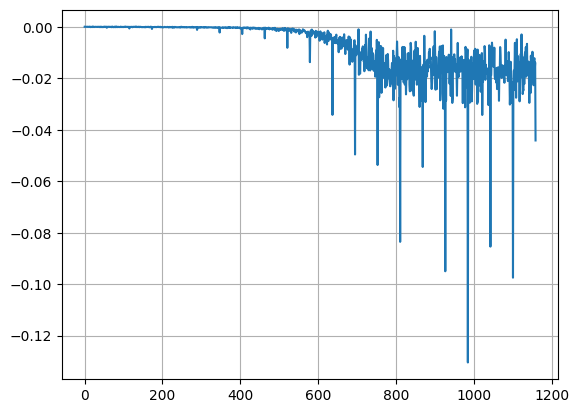

In [152]:
# optimizer = optim.Adam(dev_layer.parameters(), lr=0.002)
optimizer = optim.SGD(dev_layer.parameters(), lr=0.0001, momentum=0.99)

lossx = train_model_multichannels(
    dev_layer, optimizer, train_loader, hidden_size, num_epochs=20, alpha=0.08, beta=0.6
)
_, ax = plt.subplots()
ax.plot(range(len(lossx)), lossx)
ax.grid()

In [153]:
dev_layer.eval()

dev_train = dev_layer(tsx_train)
dt0 = dev_train[y_train == 0]
dt1 = dev_train[y_train == 1]
dt2 = dev_train[y_train == 2]
dt3 = dev_train[y_train == 3]
dt4 = dev_train[y_train == 4]
dt5 = dev_train[y_train == 5]
tau0 = torch.mean(dt0, axis=0)
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)
tau3 = torch.mean(dt3, axis=0)
tau4 = torch.mean(dt4, axis=0)
tau5 = torch.mean(dt5, axis=0)

diff0 = (dev_train - tau0).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff1 = (dev_train - tau1).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff2 = (dev_train - tau2).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff3 = (dev_train - tau3).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff4 = (dev_train - tau4).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff5 = (dev_train - tau5).reshape((len(y_train) * nchannels, hidden_size, hidden_size))

dd0 = (
    torch.swapaxes(diff0, 1, 2)
    .bmm(diff1)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd3 = (
    torch.swapaxes(diff3, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd4 = (
    torch.swapaxes(diff4, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd5 = (
    torch.swapaxes(diff5, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

dd = torch.stack([dd0, dd1, dd2, dd3, dd4, dd5])
c = dd.argmin(dim=0)
print("train accuracy : ", (y_train == c).sum().numpy() / len(y_train))

dev_test = dev_layer(tsx_test)

diff0 = (dev_test - tau0).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff1 = (dev_test - tau1).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff2 = (dev_test - tau2).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff3 = (dev_test - tau3).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff4 = (dev_test - tau4).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff5 = (dev_test - tau5).reshape((len(y_test) * nchannels, hidden_size, hidden_size))

dd0 = (
    torch.swapaxes(diff0, 1, 2)
    .bmm(diff1)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd3 = (
    torch.swapaxes(diff3, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd4 = (
    torch.swapaxes(diff4, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd5 = (
    torch.swapaxes(diff5, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

dd_test = torch.stack([dd0, dd1, dd2, dd3, dd4, dd5])
c_test = dd_test.argmin(dim=0)
print("test accuracy : ", (y_test.numpy() == c_test.numpy()).sum() / len(y_test))

train accuracy :  0.6067736670293797
test accuracy :  0.5955208686800135


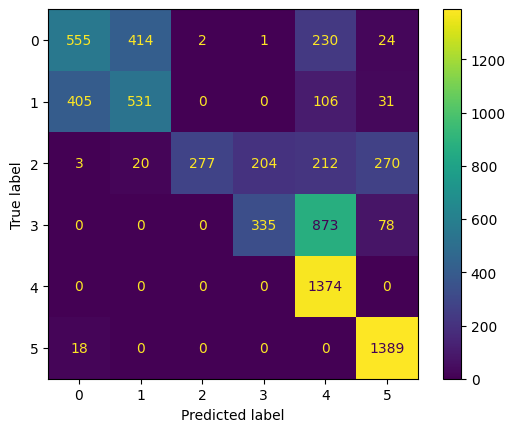

In [154]:
cm = confusion_matrix(y_train, c)
ConfusionMatrixDisplay(cm).plot()

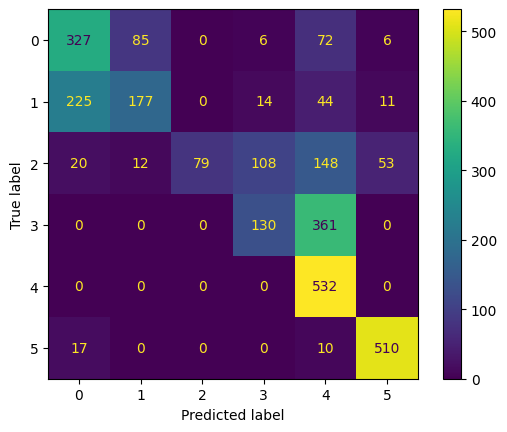

In [155]:
cm_test = confusion_matrix(y_test, c_test)
ConfusionMatrixDisplay(cm_test).plot()

## Multi-Head path development model

In [25]:
class FullModel(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        in_dim1 = (
            multidev_config.groups[0].channels * multidev_config.groups[0].dim ** 2
        )
        in_dim2 = (
            multidev_config.groups[0].channels * multidev_config.groups[1].dim ** 2
        )
        self.l1 = nn.Linear(in_dim1, out_dim)
        self.l2 = nn.Linear(in_dim2, out_dim)

    def forward_partial(self, x: Tensor):
        s1, s2 = self.atdev(x)
        return s1, s2

    def forward(self, x: Tensor):
        s1, s2 = self.atdev(x)
        y1 = self.l1(s1.view(len(s1), -1))
        y2 = self.l2(s2.view(len(s2), -1))
        return y1 + y2

In [26]:
n_class = 6
batch_size = 128

multidev_config = AttentionDevelopmentConfig(
    n_heads=2,
    groups=[
        GroupConfig(group=so, dim=4, channels=3),
        GroupConfig(group=so, dim=4, channels=3),
    ],
)

fm = FullModel(
    dropout=0.05,
    input_dim=3,
    hidden_dim=6,
    out_dim=n_class,
    multidev_config=multidev_config,
).to(device)

In [26]:
nepochs = 50
learning_rate = 1e-3

In [ ]:
# fm, lossx = train_model(fm, nepochs, learning_rate)

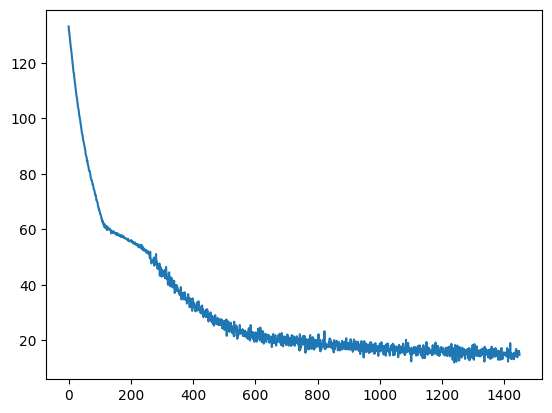

In [20]:
ax = plt.plot(range(len(lossx)), lossx)

0.8866974972796517

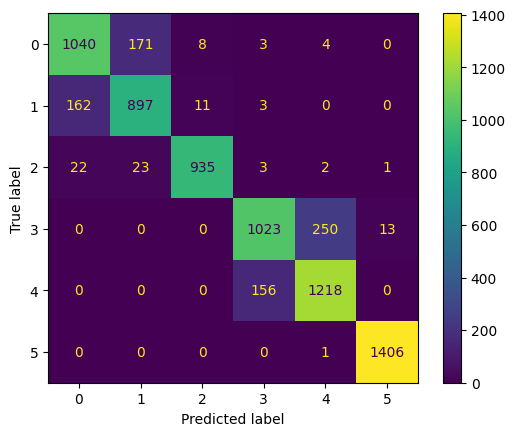

In [22]:
train_acc = train_sample_accuracy(fm)
train_acc

0.831353919239905

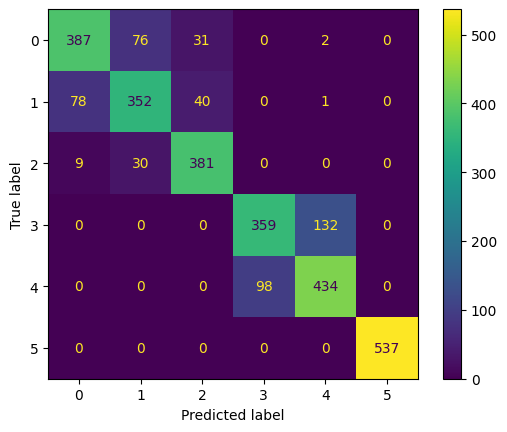

In [23]:
test_sample_accuracy(fm)

### GL
- with L1 regularization : show the evolution of the lie parameterization during training

In [41]:
class PDevBaggingClaffifier(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        head_sizes = [g.channels * g.dim**2 for g in multidev_config.groups]
        inter_dim = sum(head_sizes)
        self.lin1 = nn.Linear(inter_dim, inter_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(inter_dim, out_dim)

    def forward_partial(self, x: Tensor):
        sx = self.atdev(x)
        return sx

    def forward(self, x: Tensor):
        sx = self.atdev(x)
        sx_flat = [s.view(len(s), -1) for s in sx]
        sc = torch.cat(sx_flat, axis=-1)
        y = self.lin1(sc)
        y = self.relu(y)
        y = self.lin2(y)
        return y


class PDevBaggingClaffifierL1(nn.Module):
    """
    Include L1 regularization support to effectively learn the manifold structure
    """

    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        head_sizes = [g.channels * g.dim**2 for g in multidev_config.groups]
        inter_dim = sum(head_sizes)
        self.lin1 = nn.Linear(inter_dim, inter_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(inter_dim, out_dim)

    def forward_partial(self, x: Tensor):
        sx = self.atdev(x)
        return sx

    def lie_algebra_coefficients(self) -> List[Tensor]:
        return [
            development.projection.A for development in self.atdev.development_layers
        ]

    def forward(self, x: Tensor):
        sx = self.atdev(x)
        sx_flat = [s.view(len(s), -1) for s in sx]
        sc = torch.cat(sx_flat, axis=-1)
        y = self.lin1(sc)
        y = self.relu(y)
        y = self.lin2(y)
        return y

In [44]:
multidev_config = AttentionDevelopmentConfig(
    n_heads=3,
    groups=[
        GroupConfig(group=gl, dim=4, channels=2),
        GroupConfig(group=gl, dim=4, channels=2),
        GroupConfig(group=gl, dim=4, channels=2),
    ],
)

fm = PDevBaggingClaffifier(
    dropout=0.05,
    input_dim=3,
    hidden_dim=12,
    out_dim=n_class,
    multidev_config=multidev_config,
)


# def train_model_l2(nepochs: int, learning_rate: float, fm: nn.Module, alpha: float):
#     fm.train()
#     optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
#     lossx = []
#     for epoch in range(nepochs):
#         for x, y in tqdm(train_loader):
#             optimizer.zero_grad()
#             y_hat = fm(x)
#             s1, s2 = fm.forward_partial(x)
#             loss = (
#                 torch.sum((y - y_hat) ** 2) / len(y)
#                 + alpha * torch.linalg.norm(s1)
#                 + alpha * torch.linalg.norm(s2)
#             )  # norm parameters
#             loss.backward()
#             lossx.append(loss.item())
#             optimizer.step()

#         print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")

#     return fm, lossx

nepochs = 50
learning_rate = 5e-4
alpha = 1e-2
fm, lossx = train_model_l2(fm, train_loader, test_loader, nepochs, learning_rate, alpha)

 14%|█▍        | 4/29 [00:03<00:21,  1.14it/s]


KeyboardInterrupt: 

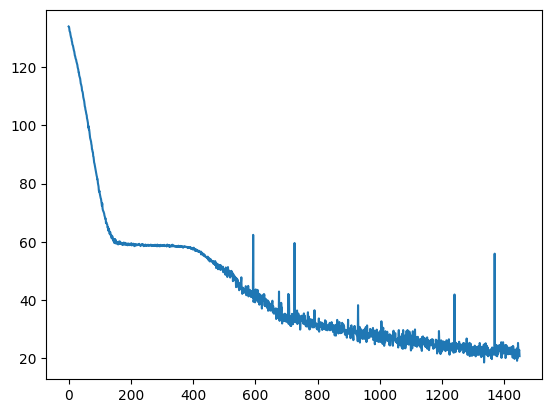

In [50]:
plt.plot(range(len(lossx)), lossx)

0.5405331882480957

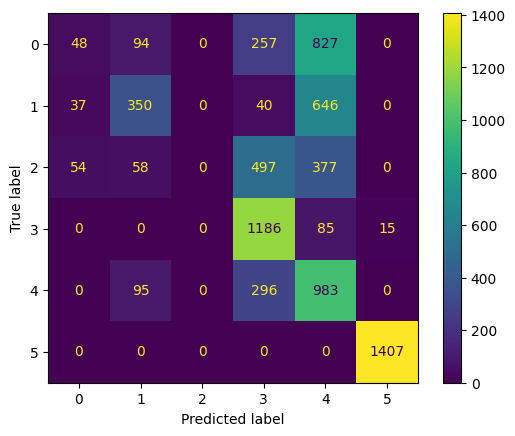

In [24]:
train_sample_accuracy(fm)

In [21]:
multidev_config = AttentionDevelopmentConfig(
    n_heads=2,
    groups=[
        GroupConfig(group=gl, dim=5, channels=2),
        GroupConfig(group=gl, dim=5, channels=2),
    ],
)

model = PDevBaggingClaffifierL1(
    dropout=0.05,
    input_dim=3,
    hidden_dim=8,
    out_dim=n_class,
    multidev_config=multidev_config,
)

In [22]:
nepochs = 10
learning_rate = 1e-3
alpha = 1e-4

model, lossx, lossx_test = train_model_l1Lie(
    model, train_loader, test_loader, nepochs, learning_rate, alpha
)

100%|██████████| 29/29 [00:09<00:00,  2.94it/s]


Epoch : 0 | Loss 88.57125091552734 | gradient 0.0


100%|██████████| 29/29 [00:10<00:00,  2.68it/s]


Epoch : 1 | Loss 59.541099548339844 | gradient 0.0


100%|██████████| 29/29 [00:10<00:00,  2.69it/s]


Epoch : 2 | Loss 58.849979400634766 | gradient 0.0


100%|██████████| 29/29 [00:10<00:00,  2.69it/s]


Epoch : 3 | Loss 58.836307525634766 | gradient 0.0


100%|██████████| 29/29 [00:10<00:00,  2.68it/s]


Epoch : 4 | Loss 58.6384162902832 | gradient 0.0


100%|██████████| 29/29 [00:10<00:00,  2.65it/s]


Epoch : 5 | Loss 58.149864196777344 | gradient 0.0


100%|██████████| 29/29 [00:10<00:00,  2.69it/s]


Epoch : 6 | Loss 55.81825256347656 | gradient 0.0


100%|██████████| 29/29 [00:10<00:00,  2.66it/s]


Epoch : 7 | Loss 49.17284393310547 | gradient 0.0


100%|██████████| 29/29 [00:11<00:00,  2.61it/s]


Epoch : 8 | Loss 42.22229766845703 | gradient 0.0


100%|██████████| 29/29 [00:11<00:00,  2.51it/s]

Epoch : 9 | Loss 34.212615966796875 | gradient 0.0


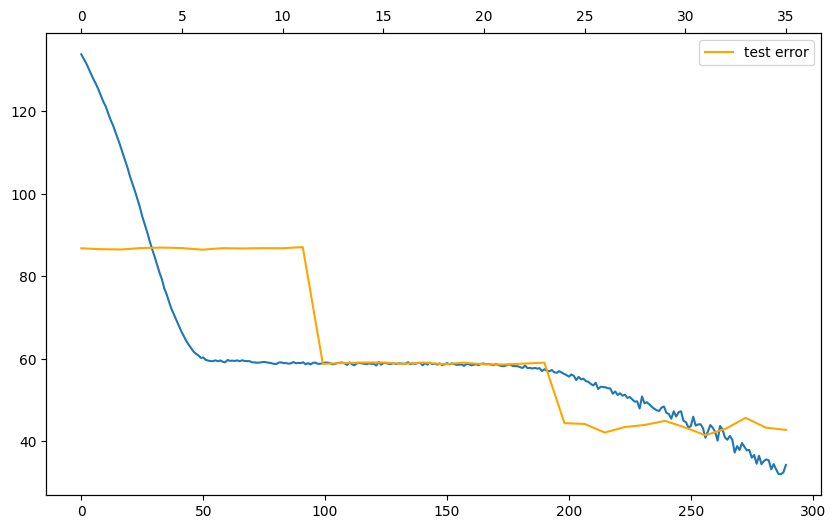

In [23]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.7612894450489662

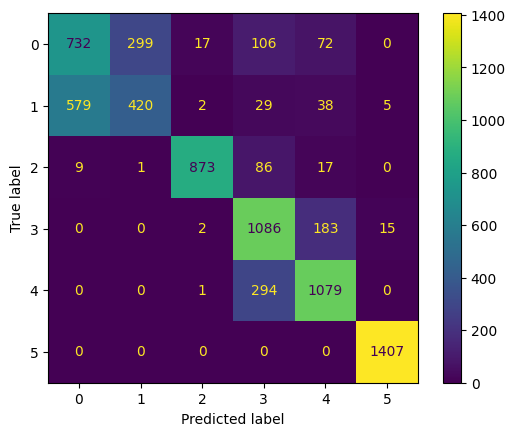

In [24]:
train_acc = train_sample_accuracy(model)
train_acc

0.7275195113674924

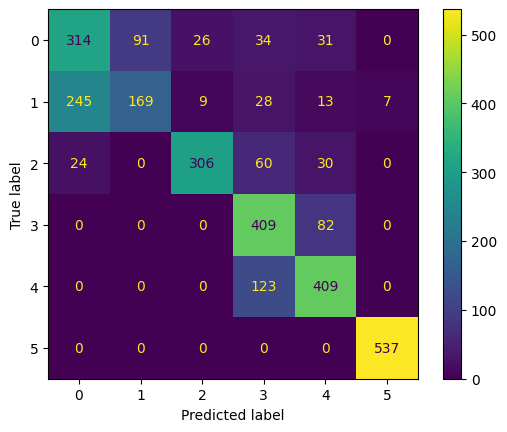

In [25]:
test_sample_accuracy(model)

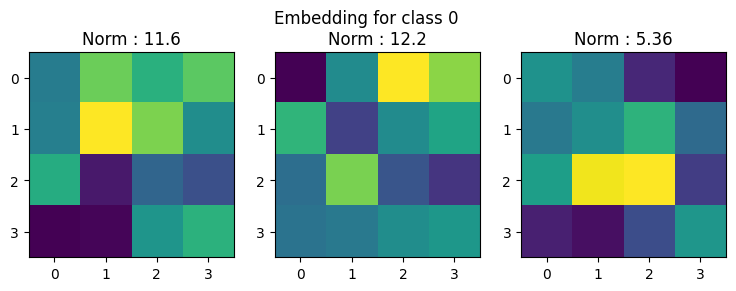

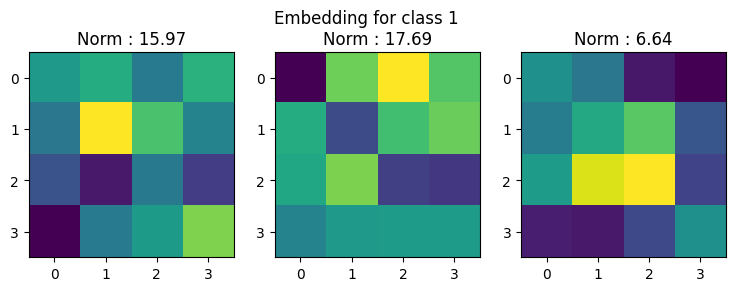

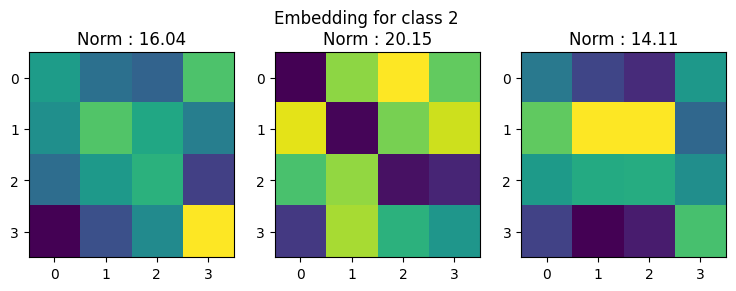

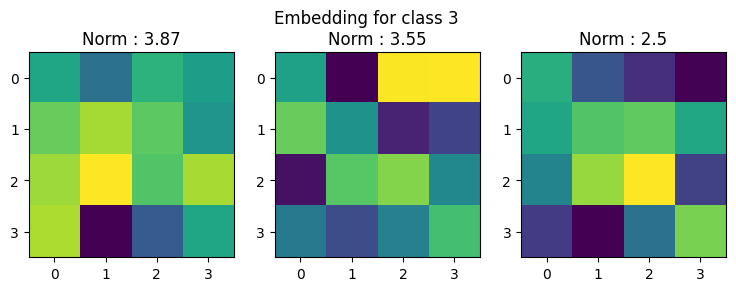

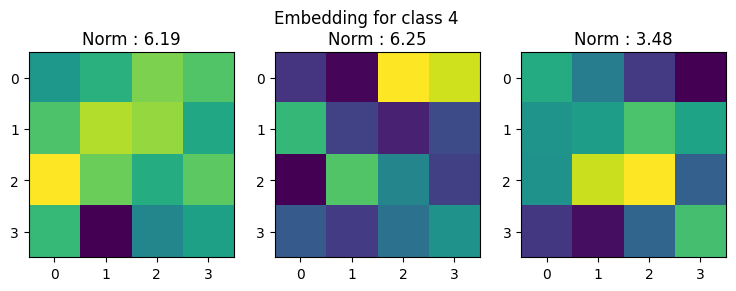

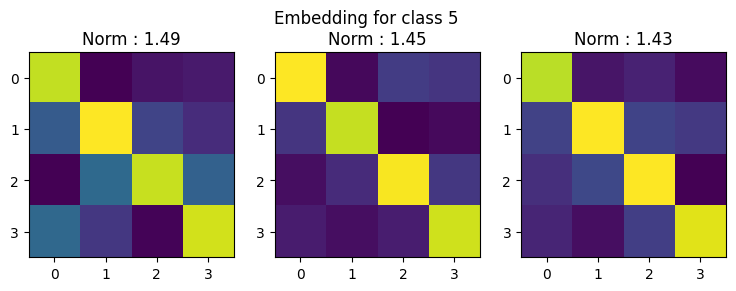

In [81]:
n_samples = 100
for label_class in range(6):
    tsx_train_class = tsx_train[y_train_labels.astype(float).astype(int) == label_class]
    s1, s2, s3 = model.forward_partial(tsx_train_class[:n_samples])
    fig, axs = plt.subplots(ncols=3, figsize=(9, 3))
    axs[0].imshow(torch.mean(s1, axis=0).cpu().detach().numpy()[0, :, :])
    axs[0].set_title(
        f"Norm : {np.round(torch.mean(torch.linalg.norm(s1, dim=(1, 2))).item(), decimals=2)}"
    )
    axs[1].imshow(torch.mean(s2, axis=0).cpu().detach().numpy()[0, :, :])
    axs[1].set_title(
        f"Norm : {np.round(torch.mean(torch.linalg.norm(s2, dim=(1, 2))).item(), decimals=2)}"
    )
    axs[2].imshow(torch.mean(s3, axis=0).cpu().detach().numpy()[0, :, :])
    axs[2].set_title(
        f"Norm : {np.round(torch.mean(torch.linalg.norm(s3, dim=(1, 2))).item(), decimals=2)}"
    )
    fig.suptitle(f"Embedding for class {label_class}")

### Sp

In [34]:
from development.sp import sp

multidev_config = AttentionDevelopmentConfig(
    n_heads=2,
    groups=[
        GroupConfig(group=sp, dim=4, channels=2),
        GroupConfig(group=sp, dim=4, channels=2),
    ],
)


model = PDevBaggingClaffifier(
    dropout=0.05,
    input_dim=3,
    hidden_dim=4,
    out_dim=n_class,
    multidev_config=multidev_config,
)

nepochs = 10
learning_rate = 1e-3
alpha = 1e-4

model, lossx, lossx_test = train_model_with_test_error(
    model, train_loader, test_loader, nepochs, learning_rate
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0 | Loss 120.05714416503906 | gradient 0.0


 20%|██        | 2/10 [00:14<00:56,  7.01s/it]

Epoch : 1 | Loss 86.98944854736328 | gradient 0.0


 30%|███       | 3/10 [00:20<00:48,  6.88s/it]

Epoch : 2 | Loss 63.00249481201172 | gradient 0.0


 40%|████      | 4/10 [00:27<00:41,  6.90s/it]

Epoch : 3 | Loss 59.020286560058594 | gradient 0.0
Epoch : 4 | Loss 58.422943115234375 | gradient 0.0


 60%|██████    | 6/10 [00:42<00:28,  7.19s/it]

Epoch : 5 | Loss 58.434295654296875 | gradient 0.0


 70%|███████   | 7/10 [00:49<00:21,  7.14s/it]

Epoch : 6 | Loss 56.24041748046875 | gradient 0.0


 80%|████████  | 8/10 [00:56<00:14,  7.12s/it]

Epoch : 7 | Loss 51.843544006347656 | gradient 0.0
Epoch : 8 | Loss 48.429264068603516 | gradient 0.0


100%|██████████| 10/10 [01:11<00:00,  7.19s/it]

Epoch : 9 | Loss 41.8381233215332 | gradient 0.0


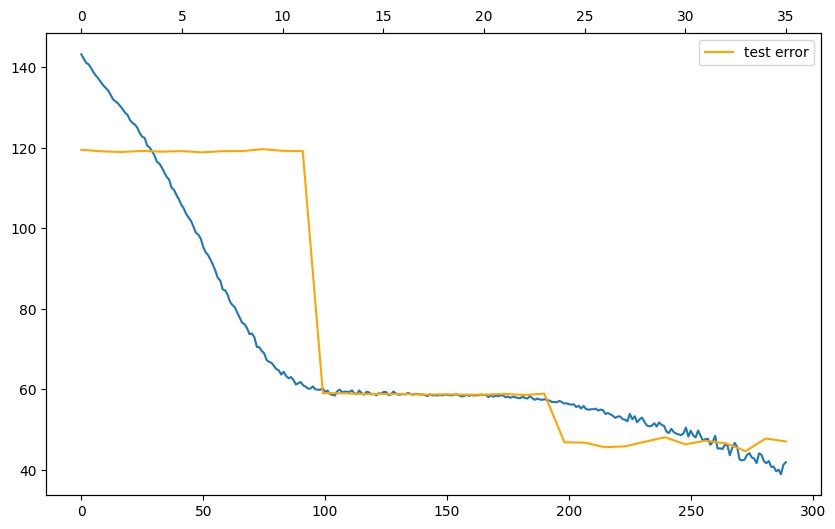

In [35]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.594804134929271

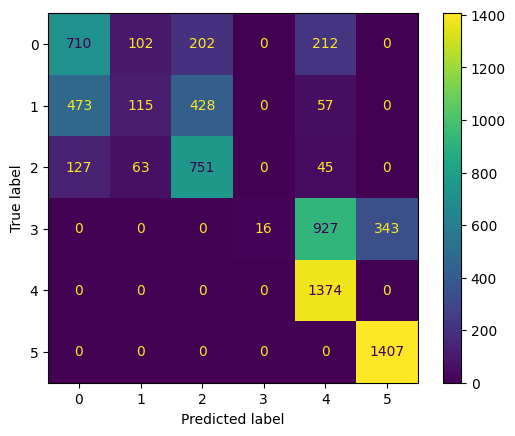

In [36]:
train_acc = train_sample_accuracy(model)
train_acc

0.5816084153376315

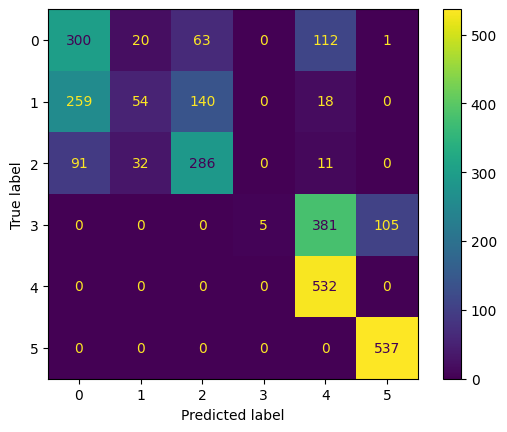

In [37]:
test_sample_accuracy(model)

### SE

In [38]:
from development.se import se

multidev_config = AttentionDevelopmentConfig(
    n_heads=2,
    groups=[
        GroupConfig(group=se, dim=4, channels=2),
        GroupConfig(group=se, dim=4, channels=2),
    ],
)


model = PDevBaggingClaffifier(
    dropout=0.05,
    input_dim=3,
    hidden_dim=4,
    out_dim=n_class,
    multidev_config=multidev_config,
)

nepochs = 10
learning_rate = 1e-3
alpha = 1e-4

model, lossx, lossx_test = train_model_with_test_error(
    model, train_loader, test_loader, nepochs, learning_rate
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0 | Loss 102.76933288574219 | gradient 0.0


 20%|██        | 2/10 [00:14<00:58,  7.27s/it]

Epoch : 1 | Loss 65.57115936279297 | gradient 0.0


 30%|███       | 3/10 [00:21<00:49,  7.05s/it]

Epoch : 2 | Loss 59.22759246826172 | gradient 0.0


 40%|████      | 4/10 [00:28<00:42,  7.09s/it]

Epoch : 3 | Loss 58.87415313720703 | gradient 0.0
Epoch : 4 | Loss 58.63640213012695 | gradient 0.0


 60%|██████    | 6/10 [00:43<00:28,  7.21s/it]

Epoch : 5 | Loss 58.29294967651367 | gradient 0.0


 70%|███████   | 7/10 [00:50<00:21,  7.09s/it]

Epoch : 6 | Loss 54.37876510620117 | gradient 0.0


 80%|████████  | 8/10 [00:56<00:13,  6.97s/it]

Epoch : 7 | Loss 49.21930694580078 | gradient 0.0
Epoch : 8 | Loss 39.81307601928711 | gradient 0.0


100%|██████████| 10/10 [01:11<00:00,  7.14s/it]

Epoch : 9 | Loss 36.98579406738281 | gradient 0.0


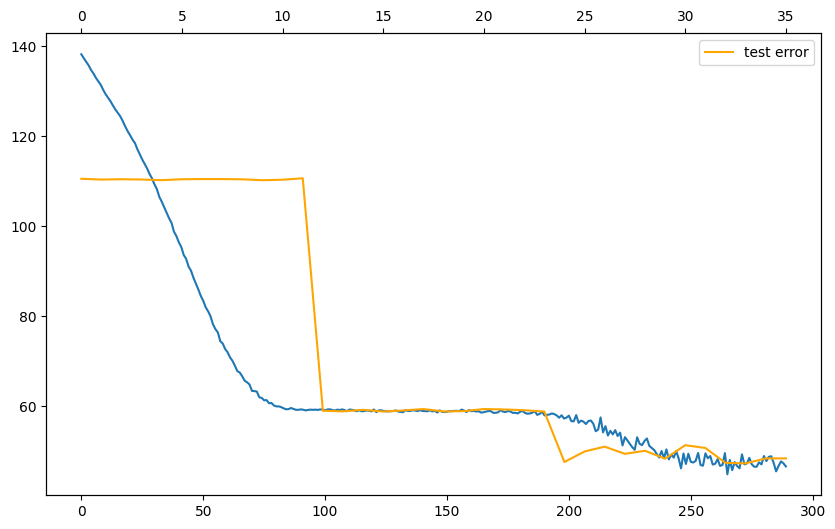

In [46]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.6726060935799782

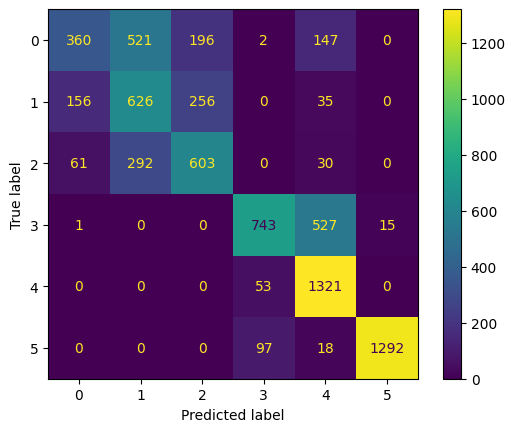

In [40]:
train_acc = train_sample_accuracy(model)
train_acc

0.6443841194435018

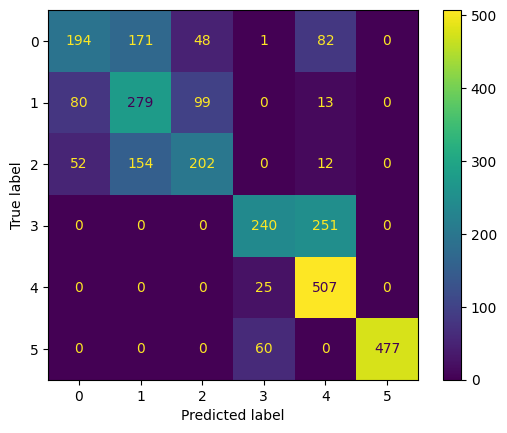

In [41]:
test_sample_accuracy(model)

### Heisenberg

In [42]:
from development.he import he

multidev_config = AttentionDevelopmentConfig(
    n_heads=2,
    groups=[
        GroupConfig(group=he, dim=4, channels=2),
        GroupConfig(group=he, dim=4, channels=2),
    ],
)


model = PDevBaggingClaffifier(
    dropout=0.05,
    input_dim=3,
    hidden_dim=4,
    out_dim=n_class,
    multidev_config=multidev_config,
)

nepochs = 10
learning_rate = 1e-3
alpha = 1e-4

model, lossx, lossx_test = train_model_with_test_error(
    model, train_loader, test_loader, nepochs, learning_rate
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0 | Loss 111.58135223388672 | gradient 0.0


 20%|██        | 2/10 [00:14<00:57,  7.23s/it]

Epoch : 1 | Loss 74.36170959472656 | gradient 0.0


 30%|███       | 3/10 [00:21<00:48,  7.00s/it]

Epoch : 2 | Loss 59.48552322387695 | gradient 0.0


 40%|████      | 4/10 [00:28<00:41,  6.97s/it]

Epoch : 3 | Loss 58.74836730957031 | gradient 0.0
Epoch : 4 | Loss 58.72947692871094 | gradient 0.0


 60%|██████    | 6/10 [00:42<00:27,  6.90s/it]

Epoch : 5 | Loss 58.680908203125 | gradient 0.0


 70%|███████   | 7/10 [00:48<00:20,  6.80s/it]

Epoch : 6 | Loss 56.528099060058594 | gradient 0.0


 80%|████████  | 8/10 [00:55<00:13,  6.76s/it]

Epoch : 7 | Loss 52.1376838684082 | gradient 0.0
Epoch : 8 | Loss 47.061248779296875 | gradient 0.0


100%|██████████| 10/10 [01:09<00:00,  6.99s/it]

Epoch : 9 | Loss 46.47983932495117 | gradient 0.0


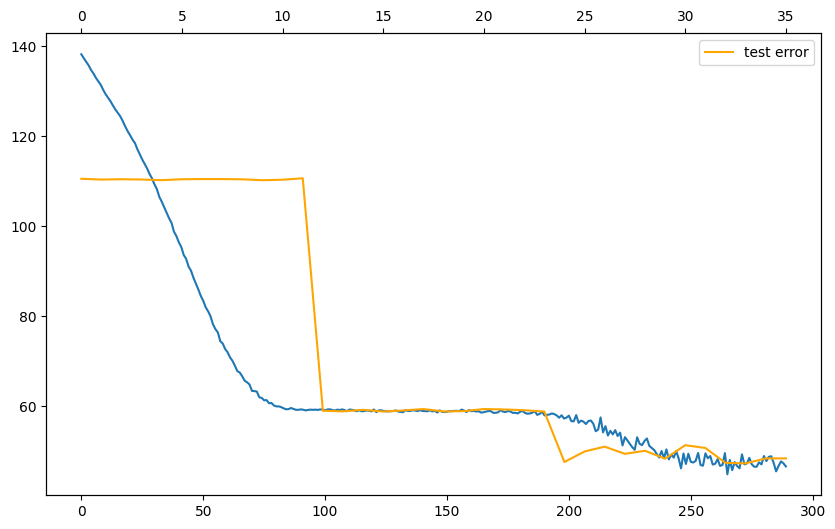

In [43]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.44056039173014144

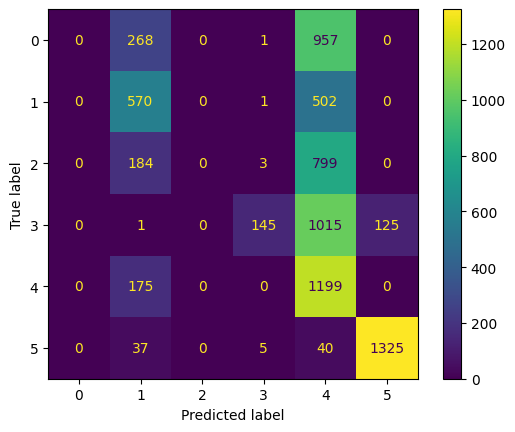

In [44]:
train_acc = train_sample_accuracy(model)
train_acc

0.4129623345775365

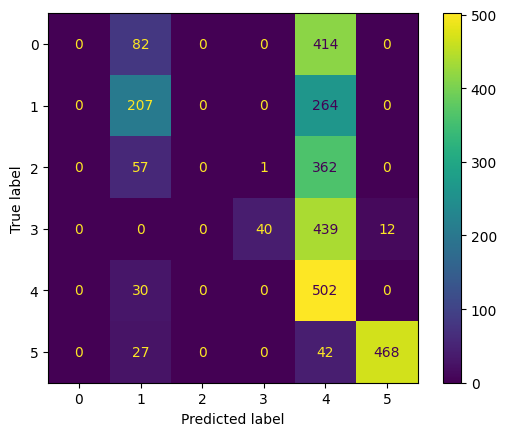

In [45]:
test_sample_accuracy(model)

# Alternative models

In [45]:
n_class = 6
multidev_config = AttentionDevelopmentConfig(
    n_heads=4,
    groups=[
        GroupConfig(group=so, dim=3, channels=3),
        GroupConfig(group=so, dim=4, channels=3),
        # GroupConfig(group=so, dim=5, channels=3),
    ],
)

fm = PDevBaggingClaffifier(
    dropout=0.05,
    input_dim=3,
    hidden_dim=12,
    out_dim=n_class,
    multidev_config=multidev_config,
)

# ? number of parameters

params = list(fm.parameters())
n_params = np.sum([np.prod(t.shape) for t in params])
n_params

7149

In [46]:
nepochs = 40
learning_rate = 5e-4

# fm, lossx = train_model(fm, nepochs, learning_rate)
fm, lossx, lossx_test = train_model_with_test_error(
    fm, train_loader, test_loader, nepochs, learning_rate
)

  0%|          | 0/40 [00:03<?, ?it/s]


KeyboardInterrupt: 

NameError: name 'lossx_test' is not defined

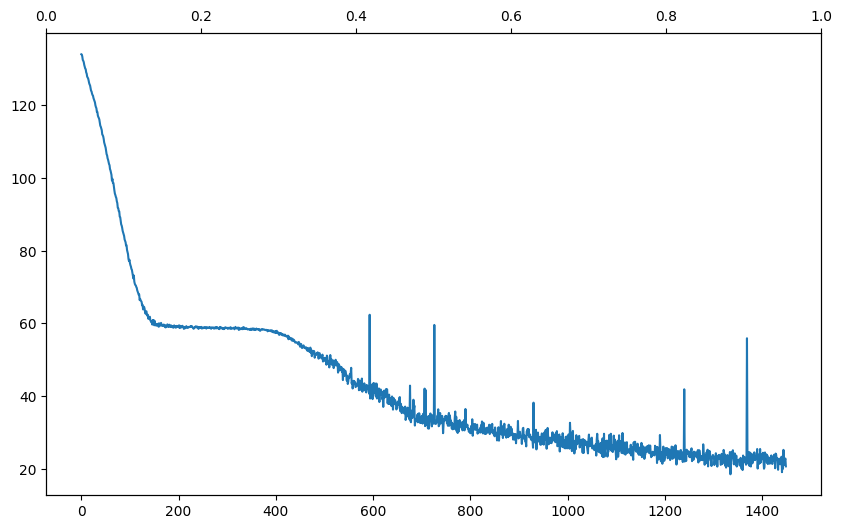

In [51]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.7902611534276387

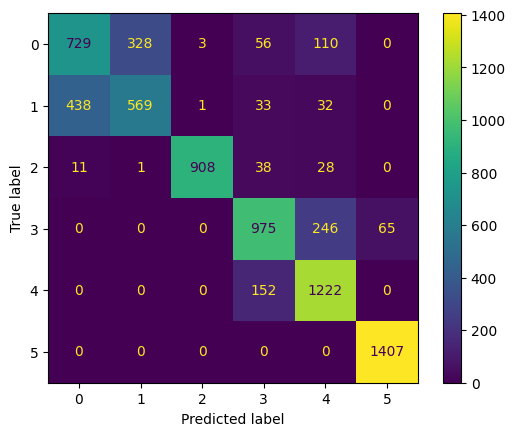

In [56]:
train_acc = train_sample_accuracy(model)
train_acc

0.7370206990159485

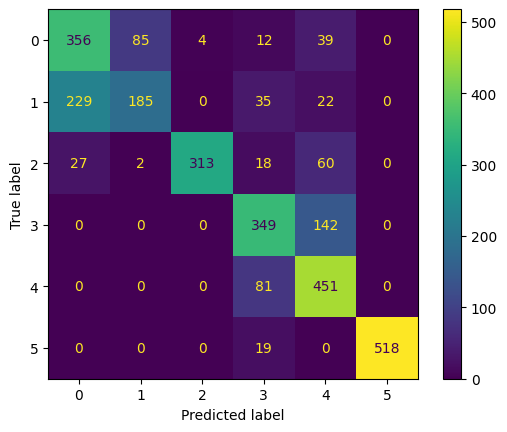

In [57]:
test_sample_accuracy(model)

## Bi LSTM feature extraction

In [67]:
class PDevBaggingBiLSTM(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
        bidirectional: bool = False,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, batch_first=True, bidirectional=bidirectional
        )
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        head_sizes = [g.channels * g.dim**2 for g in multidev_config.groups]
        inter_dim = sum(head_sizes)
        self.lin1 = nn.Linear((1 + int(bidirectional)) * inter_dim, inter_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(inter_dim, out_dim)

    def forward_partial(self, x: Tensor):
        x, _ = self.lstm(x)
        sx = self.atdev(x)
        return sx

    def lie_algebra_coefficients(self) -> List[Tensor]:
        return [
            development.projection.A for development in self.atdev.development_layers
        ]

    def forward(self, x: Tensor):
        x, _ = self.lstm(x)
        sx = self.atdev(x)
        sx_flat = [s.view(len(s), -1) for s in sx]
        sc = torch.cat(sx_flat, axis=-1)
        y = self.lin1(sc)
        y = self.relu(y)
        y = self.lin2(y)
        return y

In [29]:
n_class = 6
multidev_config = AttentionDevelopmentConfig(
    n_heads=4,
    groups=[
        GroupConfig(group=so, dim=3, channels=2),
        GroupConfig(group=so, dim=3, channels=2),
        GroupConfig(group=so, dim=3, channels=2),
        GroupConfig(group=so, dim=3, channels=2),
    ],
)

fm = PDevBaggingBiLSTM(
    dropout=0.05,
    input_dim=3,
    hidden_dim=12,
    out_dim=n_class,
    multidev_config=multidev_config,
)

# ? number of parameters

params = list(fm.parameters())
n_params = np.sum([np.prod(t.shape) for t in params])
n_params

8634

In [31]:
nepochs = 50
learning_rate = 1e-3
# fm, lossx = train_model(fm, nepochs, learning_rate)
fm, lossx, lossx_test = train_model_with_test_error(
    fm, train_loader, test_loader, nepochs, learning_rate
)

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (52736x24 and 12x12)

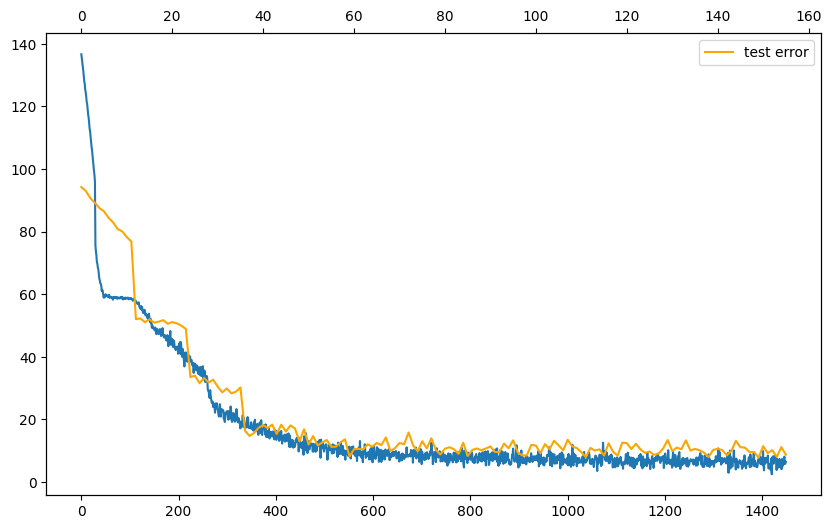

In [42]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.9047878128400435

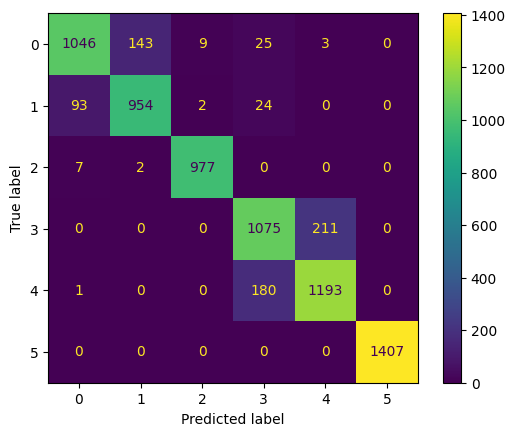

In [24]:
train_acc = train_sample_accuracy(fm)
train_acc

0.8656260604004072

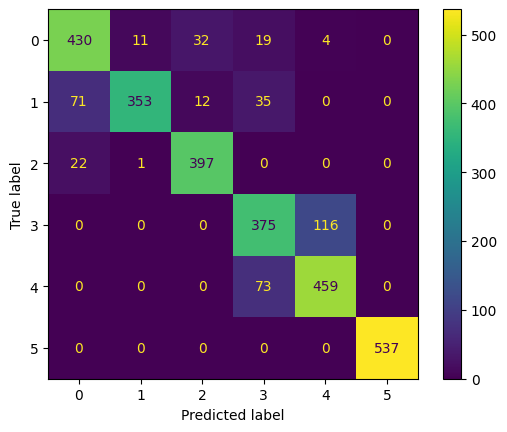

In [25]:
test_sample_accuracy(fm)

#### With GL instead : need to regularize ?

In [71]:
n_class = 6
multidev_config = AttentionDevelopmentConfig(
    n_heads=3,
    groups=[
        GroupConfig(group=gl, dim=4, channels=2),
        GroupConfig(group=gl, dim=4, channels=2),
        GroupConfig(group=gl, dim=4, channels=2),
    ],
)

model = PDevBaggingBiLSTM(
    # model = PDevBaggingClaffifierL1(
    dropout=0.05,
    input_dim=3,
    hidden_dim=12,
    out_dim=n_class,
    multidev_config=multidev_config,
)

# ? number of parameters

params = list(model.parameters())
n_params = np.sum([np.prod(t.shape) for t in params])
n_params

12186

In [72]:
nepochs = 50
learning_rate = 1e-3
alpha = 1e-4
# fm, lossx = train_model(fm, nepochs, learning_rate)
# fm, lossx, lossx_test = train_model_l2(
#     fm, train_loader, test_loader, nepochs, learning_rate, alpha
# )


model, lossx, lossx_test = train_model_l1Lie_l2(
    model, train_loader, test_loader, nepochs, learning_rate, alpha
)

100%|██████████| 29/29 [00:19<00:00,  1.47it/s]


Epoch : 0 | Loss 85.79492950439453 | gradient 0.0


100%|██████████| 29/29 [00:19<00:00,  1.46it/s]


Epoch : 1 | Loss 59.02835464477539 | gradient 0.0


100%|██████████| 29/29 [00:19<00:00,  1.45it/s]


Epoch : 2 | Loss 58.29848098754883 | gradient 0.0


100%|██████████| 29/29 [00:19<00:00,  1.46it/s]


Epoch : 3 | Loss 50.86825180053711 | gradient 0.0


100%|██████████| 29/29 [00:19<00:00,  1.51it/s]


Epoch : 4 | Loss 47.2790412902832 | gradient 0.0


100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


Epoch : 5 | Loss 42.207611083984375 | gradient 0.0


100%|██████████| 29/29 [00:19<00:00,  1.46it/s]


Epoch : 6 | Loss 41.40281295776367 | gradient 0.0


100%|██████████| 29/29 [01:57<00:00,  4.03s/it]


Epoch : 7 | Loss 29.80829620361328 | gradient 0.0


100%|██████████| 29/29 [00:50<00:00,  1.75s/it]


Epoch : 8 | Loss 22.66455078125 | gradient 0.0


100%|██████████| 29/29 [00:55<00:00,  1.91s/it]


Epoch : 9 | Loss 17.18947982788086 | gradient 0.0


100%|██████████| 29/29 [00:51<00:00,  1.77s/it]


Epoch : 10 | Loss 18.704879760742188 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch : 11 | Loss 15.337714195251465 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch : 12 | Loss 13.422097206115723 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch : 13 | Loss 12.579559326171875 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch : 14 | Loss 12.488834381103516 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch : 15 | Loss 13.608155250549316 | gradient 0.0


100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


Epoch : 16 | Loss 11.653220176696777 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch : 17 | Loss 11.4917631149292 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch : 18 | Loss 9.602893829345703 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch : 19 | Loss 12.792631149291992 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch : 20 | Loss 8.865005493164062 | gradient 0.0


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch : 21 | Loss 10.370262145996094 | gradient 0.0


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch : 22 | Loss 7.50538969039917 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch : 23 | Loss 9.158003807067871 | gradient 0.0


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


Epoch : 24 | Loss 7.398553371429443 | gradient 0.0


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch : 25 | Loss 11.005617141723633 | gradient 0.0


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch : 26 | Loss 10.418455123901367 | gradient 0.0


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Epoch : 27 | Loss 7.878146171569824 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch : 28 | Loss 10.312771797180176 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch : 29 | Loss 11.01132583618164 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch : 30 | Loss 8.165980339050293 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 31 | Loss 8.017411231994629 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 32 | Loss 9.808473587036133 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 33 | Loss 11.472818374633789 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch : 34 | Loss 10.899162292480469 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch : 35 | Loss 9.149138450622559 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch : 36 | Loss 8.311399459838867 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 37 | Loss 7.354172229766846 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 38 | Loss 5.538757801055908 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch : 39 | Loss 7.154536247253418 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch : 40 | Loss 8.766940116882324 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 41 | Loss 7.1892499923706055 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch : 42 | Loss 9.135482788085938 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch : 43 | Loss 9.452408790588379 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 44 | Loss 8.012340545654297 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 45 | Loss 6.545551776885986 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 46 | Loss 7.774280548095703 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch : 47 | Loss 8.539728164672852 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch : 48 | Loss 5.660496711730957 | gradient 0.0


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]

Epoch : 49 | Loss 5.996411323547363 | gradient 0.0


In [80]:
channel_range = range(2, 5)
dim_range = range(3, 10)
hidden_size_range = [4, 6, 10, 15, 20]
heads_range = range(2, 3)
lstm_is_bidirectional = [True, False]


res = pd.DataFrame(
    columns=["train_acc", "test_acc"],
    index=pd.MultiIndex.from_product(
        [
            channel_range,
            dim_range,
            heads_range,
            hidden_size_range,
            lstm_is_bidirectional,
        ],
        names=["nchannels", "dim", "n_heads", "hidden_size", "bidirectional"],
    ),
)

for nchannels, dim, n_heads, hidden_size, bidirectional in res.index.to_series():
    print(nchannels, dim, n_heads, hidden_size, bidirectional)

2 3 2 4 True
2 3 2 4 False
2 3 2 6 True
2 3 2 6 False
2 3 2 10 True
2 3 2 10 False
2 3 2 15 True
2 3 2 15 False
2 3 2 20 True
2 3 2 20 False
2 4 2 4 True
2 4 2 4 False
2 4 2 6 True
2 4 2 6 False
2 4 2 10 True
2 4 2 10 False
2 4 2 15 True
2 4 2 15 False
2 4 2 20 True
2 4 2 20 False
2 5 2 4 True
2 5 2 4 False
2 5 2 6 True
2 5 2 6 False
2 5 2 10 True
2 5 2 10 False
2 5 2 15 True
2 5 2 15 False
2 5 2 20 True
2 5 2 20 False
2 6 2 4 True
2 6 2 4 False
2 6 2 6 True
2 6 2 6 False
2 6 2 10 True
2 6 2 10 False
2 6 2 15 True
2 6 2 15 False
2 6 2 20 True
2 6 2 20 False
2 7 2 4 True
2 7 2 4 False
2 7 2 6 True
2 7 2 6 False
2 7 2 10 True
2 7 2 10 False
2 7 2 15 True
2 7 2 15 False
2 7 2 20 True
2 7 2 20 False
2 8 2 4 True
2 8 2 4 False
2 8 2 6 True
2 8 2 6 False
2 8 2 10 True
2 8 2 10 False
2 8 2 15 True
2 8 2 15 False
2 8 2 20 True
2 8 2 20 False
2 9 2 4 True
2 9 2 4 False
2 9 2 6 True
2 9 2 6 False
2 9 2 10 True
2 9 2 10 False
2 9 2 15 True
2 9 2 15 False
2 9 2 20 True
2 9 2 20 False
3 3 2 4 True


In [73]:
model.lie_algebra_coefficients()

[Parameter containing:
 tensor([[[[-0.2861,  0.1864,  0.5062,  0.2083],
           [-0.0344,  0.2547,  0.1572, -0.0923],
           [ 0.3992, -0.4203,  0.0246, -0.1705],
           [ 0.1941,  0.1049,  0.1266, -0.0704]],
 
          [[ 0.1134, -0.4756, -0.2720,  0.0236],
           [ 0.0866, -0.3732, -0.4202, -0.3384],
           [-0.3716, -0.4004,  0.2593, -0.1530],
           [ 0.3725, -0.1727, -0.0360, -0.1848]]],
 
 
         [[[ 0.1081,  0.4359, -0.0303,  0.5106],
           [-0.4645, -0.3500, -0.3084,  0.1941],
           [ 0.4484, -0.0277,  0.1746, -0.3768],
           [-0.5102,  0.0222,  0.4401,  0.0742]],
 
          [[-0.2462, -0.0092, -0.3045,  0.0448],
           [ 0.3379, -0.0657, -0.2392,  0.2507],
           [ 0.1698, -0.2962,  0.0937,  0.3059],
           [-0.2393, -0.4210, -0.1084, -0.3045]]],
 
 
         [[[-0.1096, -0.3844, -0.5519,  0.1026],
           [ 0.2806,  0.1858, -0.0131, -0.0849],
           [-0.5526,  0.6856,  0.1074,  0.3550],
           [ 0.4792,  0.1818

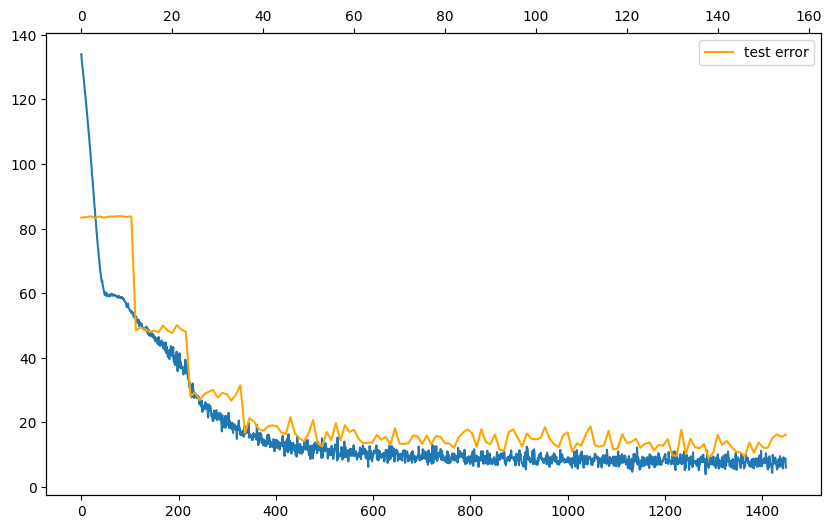

In [74]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.9421926006528836

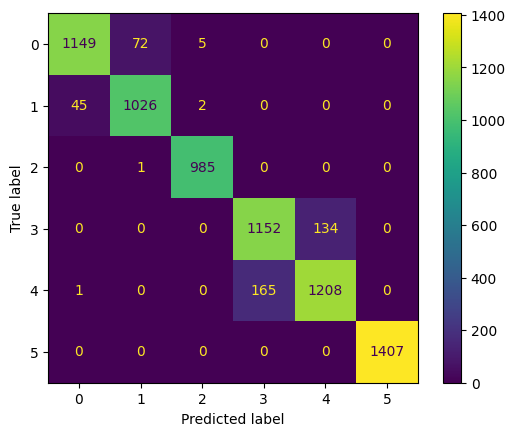

In [75]:
train_acc = train_sample_accuracy(model)
train_acc

0.8876823888700374

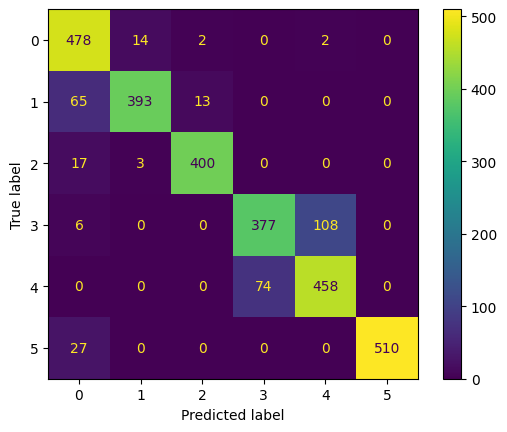

In [76]:
test_sample_accuracy(model)

## LSTM weight aggregation

- groups would need to be of the same size
- weighted mean of all groups
- learn on residual instead ?

<img src="LSTM_weighting.jpg" width=800 height=200 />

In [ ]:
class PDevLSTMAggregation(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        ngroups = sum([g.channels for g in multidev_config.groups])
        self.lstm = nn.LSTM(input_dim, ngroups, batch_first=True, bidirectional=False)
        head_sizes = [g.channels * g.dim**2 for g in multidev_config.groups]
        inter_dim = sum(head_sizes)
        self.lin1 = nn.Linear(inter_dim, inter_dim)
        # self.relu = nn.ReLU()
        self.lin2 = nn.Linear(inter_dim, out_dim)

    def forward_partial(self, x: Tensor):
        x, _ = self.lstm(x)
        sx = self.atdev(x)
        return sx

    def forward(self, x: Tensor):
        x, _ = self.lstm(x)
        sx = self.atdev(x)
        sx_flat = [s.view(len(s), -1) for s in sx]
        sc = torch.cat(sx_flat, axis=-1)
        y = self.lin1(sc)
        y = self.relu(y)
        y = self.lin2(y)
        return y

## CNN initial filter 
- make sure attention done on the right dimension (along the paths rather than accross the features)
- add initial 1-kernel CNN layer before attention

In [ ]:
class CNNFilter(nn.module):
    def __init__(self, input_dim: int, channels: int, out_dim: int):
        super().__init__(self)
        self.conv1 = nn.Conv1d(input_dim, channels, 3, stride=1, dilation=1)
        self.relu = nn.ReLU()
        self.bnorm1 = nn.BatchNorm(channels)
        self.conv2 = nn.Conv1d(channels, 2 * channels, 5, stride=2, dilation=3)

    def forward(self, x):
        return x


class PDevBaggingCNN(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        conv_channels: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.conv = CNNFilter(input_dim, conv_channels, hidden_dim)
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        head_sizes = [g.channels * g.dim**2 for g in multidev_config.groups]
        inter_dim = sum(head_sizes)
        self.lin1 = nn.Linear(inter_dim, inter_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(inter_dim, out_dim)

    def forward_partial(self, x: Tensor):
        x, _ = self.lstm(x)
        sx = self.atdev(x)
        return sx

    def forward(self, x: Tensor):
        x, _ = self.lstm(x)
        sx = self.atdev(x)
        sx_flat = [s.view(len(s), -1) for s in sx]
        sc = torch.cat(sx_flat, axis=-1)
        y = self.lin1(sc)
        y = self.relu(y)
        y = self.lin2(y)
        return y

# Compare with MiniRocket
- adapted to rather small datasets

In [8]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)

In [23]:
minirocket = MiniRocketMultivariate(
    num_kernels=10000
)  # by default, MiniRocket uses ~10_000 kernels
minirocket.fit(tsx_train.cpu().detach().numpy().swapaxes(1, 2))
X_train_transform = minirocket.transform(
    tsx_train.cpu().detach().numpy().swapaxes(1, 2)
)

scaler = StandardScaler(with_mean=False)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

X_train_scaled_transform = scaler.fit_transform(X_train_transform)
classifier.fit(X_train_scaled_transform, y_train_labels)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [26]:
X_test_transform = minirocket.transform(tsx_test.cpu().detach().numpy().swapaxes(1, 2))

In [27]:
X_test_scaled_transform = scaler.transform(X_test_transform)
classifier.score(X_test_scaled_transform, y_test_labels)

0.9260264675941635

In [28]:
X_test_scaled_transform.shape

(2947, 14952)

### Showing saturation of learning with increasing number of kernels
- In the interpolating regime, does not improve test accuracy
- Finds the convolution kernels that interpolate the dataset, when there are too many of them, the regularisation becomes inefficient ?

In [8]:
tsx_train_skt = tsx_train.cpu().detach().numpy().swapaxes(1, 2)
tsx_test_skt = tsx_test.cpu().detach().numpy().swapaxes(1, 2)

In [39]:
num_kernels_range = np.logspace(
    start=2, stop=4.5, endpoint=True, num=15, base=10.0, dtype=int
)


train_accuracyx, test_accuracyx = [], []

for num_kernels in num_kernels_range:
    print(num_kernels)
    minirocket = MiniRocketMultivariate(
        num_kernels=num_kernels
    )  # by default, MiniRocket uses ~10_000 kernels
    minirocket.fit(tsx_train_skt)
    X_train_transform = minirocket.transform(tsx_train_skt)

    scaler = StandardScaler(with_mean=False)
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

    X_train_scaled_transform = scaler.fit_transform(X_train_transform)
    classifier.fit(X_train_scaled_transform, y_train_labels)

    train_accuracyx.append(classifier.score(X_train_scaled_transform, y_train_labels))

    X_test_transform = minirocket.transform(tsx_test_skt)

    X_test_scaled_transform = scaler.transform(X_test_transform)
    test_accuracyx.append(classifier.score(X_test_scaled_transform, y_test_labels))

100
163
268
439
719
1178
1930
3162
5179
8483
13894
22758
37275


KeyboardInterrupt: 

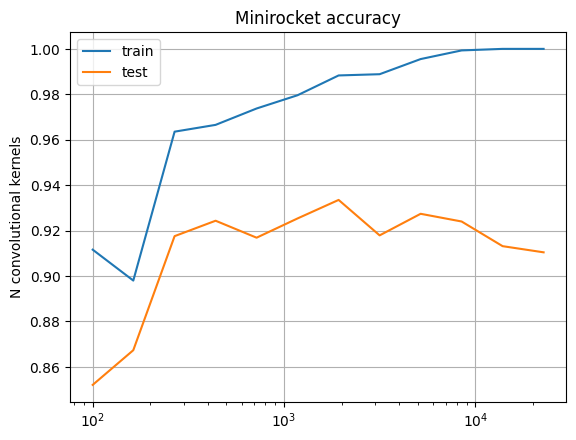

In [44]:
_, ax = plt.subplots()
ax.plot(num_kernels_range[:12], train_accuracyx, label="train")
ax.plot(num_kernels_range[:12], test_accuracyx, label="test")
ax.legend()
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_title("Minirocket accuracy")
ax.set_ylabel("%")
ax.set_ylabel("N convolutional kernels")
ax.grid()

# Signature classifier 
- hyperparameter tuning

In [9]:
from sktime.classification.feature_based import SignatureClassifier

In [10]:
sigclassifier = SignatureClassifier()

sigclassifier.fit(tsx_train_skt, y_train_labels)

SignatureClassifier()

In [11]:
sigclassifier.score(tsx_train_skt, y_train_labels)

1.0

In [12]:
sigclassifier.score(tsx_test_skt, y_test_labels)

0.831353919239905